In [26]:
%load_ext autoreload
%autoreload 2

In [1]:
from hydra import initialize, compose
from omegaconf import OmegaConf
from pathlib import Path
from tqdm import tqdm

import sys 
sys.path.insert(0, "../src")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

from dataloader import SingleCellAndCodexDataset 
from model import FlowMatchingModelWrapper
from torch.utils.data import random_split
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

plt.rcParams['figure.figsize'] = (4, 3) 

In [3]:
with initialize(config_path="../configs/"):
    # Step 2: Compose the configuration
    config_dict = compose(config_name="train")  # replace 'config' with your actual config name

/tmp/ipykernel_1554031/281137910.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../configs/"):


Dataset

In [4]:
dataset = SingleCellAndCodexDataset(config_dict.datamodule.rna_adata_path, 
                                        config_dict.datamodule.codex_adata_path, 
                                        config_dict.datamodule.label_columns, 
                                        config_dict.datamodule.obsm_key_rna, 
                                        config_dict.datamodule.obsm_key_codex, 
                                        # rna_sampling_label=None,
                                        # uniform_sampling_rna=False
                                        rna_sampling_label="annotation_figure_1", 
                                        uniform_sampling_rna=True
                                   ) 

Dataloaders

In [5]:
train_data, valid_data = random_split(dataset,
                                           lengths=[0.80, 0.20])   

train_dataloader = torch.utils.data.DataLoader(train_data,
                                                batch_size=config_dict.training_config.batch_size,
                                                shuffle=True,
                                                num_workers=6)

valid_dataloader = torch.utils.data.DataLoader(valid_data,
                                                batch_size=config_dict.training_config.batch_size,
                                                shuffle=False,
                                                num_workers=6)

In [6]:
labels = []

In [7]:
for b in tqdm(train_dataloader):
    labels += b["labels"]["annotation_figure_1"].tolist()

100%|██████████| 79/79 [00:04<00:00, 16.91it/s]


In [9]:
 np.unique(labels, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22.]),
 array([882, 899, 875, 859, 866, 852, 880, 876, 863, 846, 865, 884, 831,
        856, 843, 890, 850, 836, 899, 850, 925, 865, 893]))

Model

In [ ]:
model = FlowMatchingModelWrapper(input_dim=dataset.input_dim,
                                hidden_dim=config_dict.model.hidden_dim,
                                num_hidden_layers=config_dict.model.num_hidden_layers,
                                time_embedding_dim=config_dict.model.time_embedding_dim,
                                source_condition_dim=dataset.source_dim, 
                                use_batchnorm=config_dict.model.use_batchnorm,
                                sigma=config_dict.model.sigma, 
                                flavor=config_dict.model.flavor, 
                                learning_rate=config_dict.model.learning_rate, 
                                weight_decay=config_dict.model.weight_decay, 
                                distance=config_dict.model.distance)

Checkpoints

In [ ]:
# Callbacks for saving checkpoints 
checkpoint_callback = ModelCheckpoint(dirpath=Path(config_dict.training_config.training_dir) / "checkpoints", 
                                        **config_dict.checkpoints)
callbacks = [checkpoint_callback]

# Logger settings 
logger = WandbLogger(save_dir=config_dict.training_config.training_dir,
                    **config_dict.logger)

trainer_generative = Trainer(callbacks=callbacks, 
                                default_root_dir=config_dict.training_config.training_dir, 
                                logger=logger,
                                **config_dict.trainer)

In [13]:
# trainer_generative.fit(
#             model,
#             train_dataloaders=train_dataloader,
#             val_dataloaders=valid_dataloader)

## When already trained 

In [42]:
ckpts = torch.load("/lustre/groups/ml01/workspace/alessandro.palma/scportrait/experiements/checkpoints/epoch_449.ckpt")

In [43]:
model.load_state_dict(ckpts["state_dict"])

<All keys matched successfully>

In [44]:
adata_codex = sc.read_h5ad("/lustre/groups/ml01/workspace/alessandro.palma/scportrait/data/codex/cellfeaturization_results_healthy_processed.h5ad")

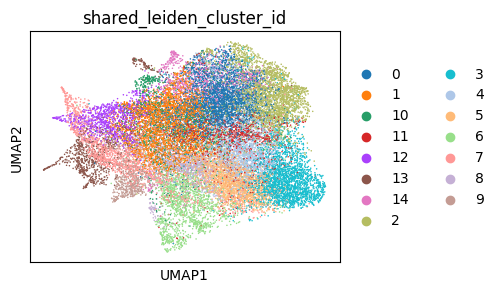

In [134]:
sc.pl.umap(adata_codex, color="shared_leiden_cluster_id")

In [47]:
adata_scrnaseq = sc.read_h5ad("/lustre/groups/ml01/workspace/alessandro.palma/scportrait/data/scrnaseq/sce_converted_processed_discovery.h5ad")
adata_scrnaseq.obsm["X_umap"] = adata_scrnaseq.obsm["UMAP"]
sc.pp.subsample(adata_scrnaseq, 0.3)

Test pushforward

Workig with cluster 0


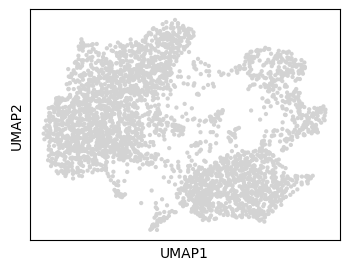

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


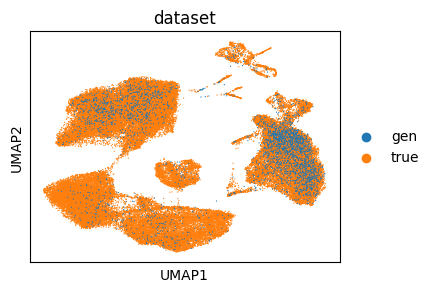

Workig with cluster 1


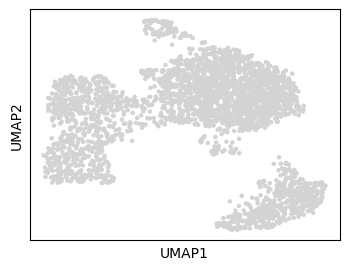

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


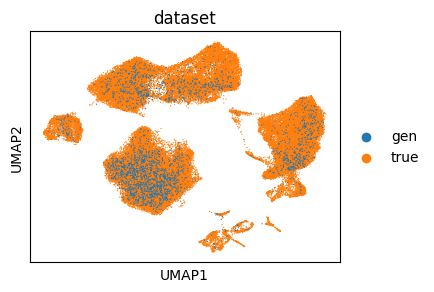

Workig with cluster 2


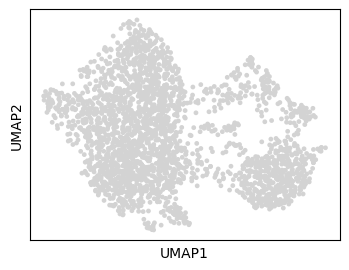

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


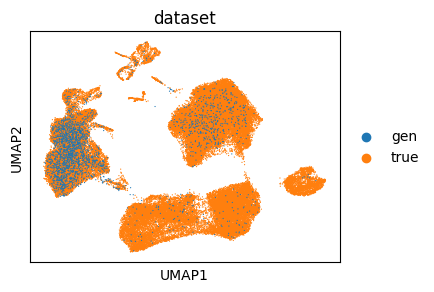

Workig with cluster 3


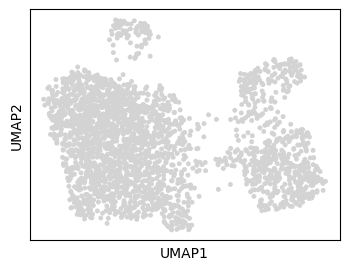

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


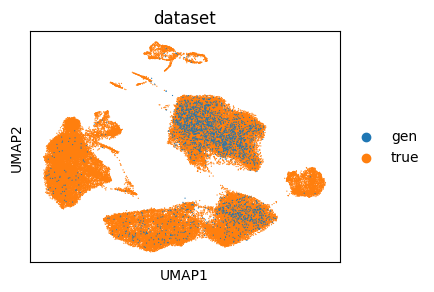

Workig with cluster 4


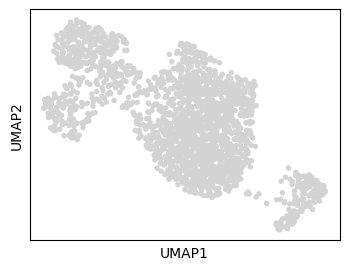

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


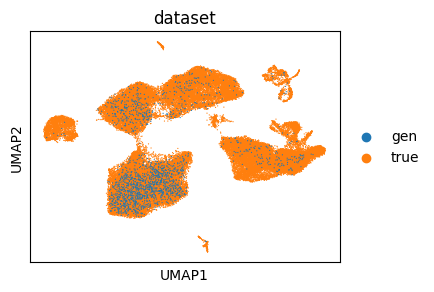

Workig with cluster 5


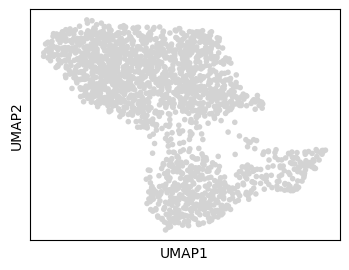

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


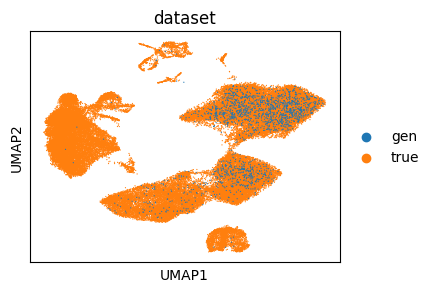

Workig with cluster 6


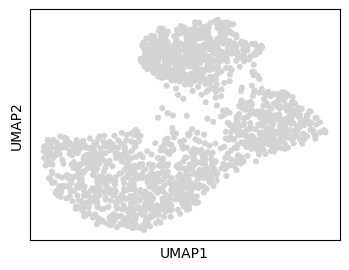

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


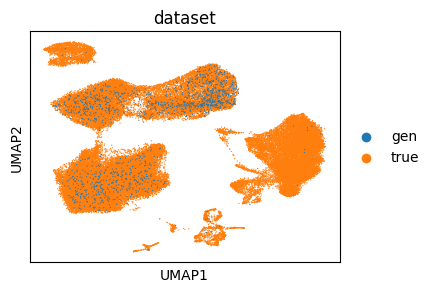

Workig with cluster 7


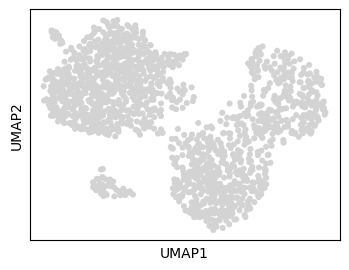

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


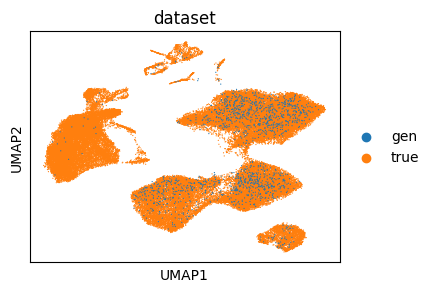

Workig with cluster 8


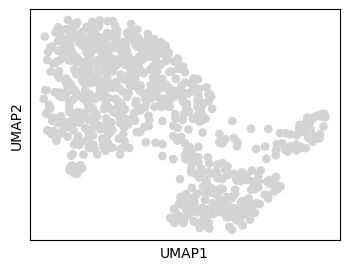

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


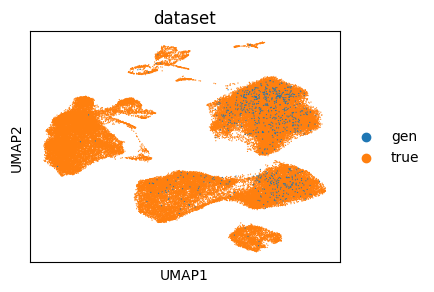

Workig with cluster 9


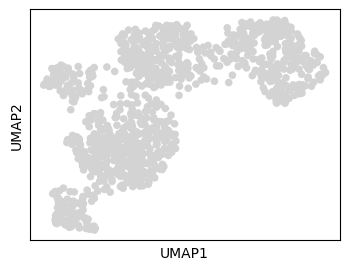

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


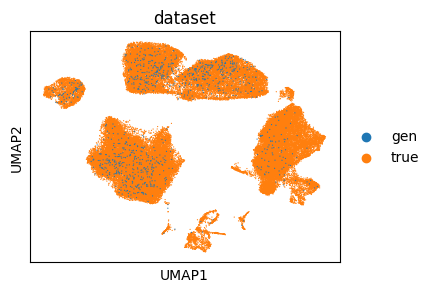

Workig with cluster 10


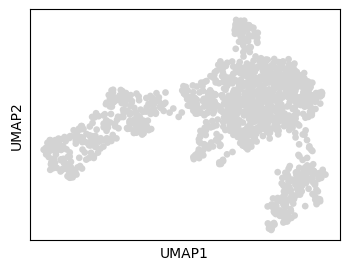

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


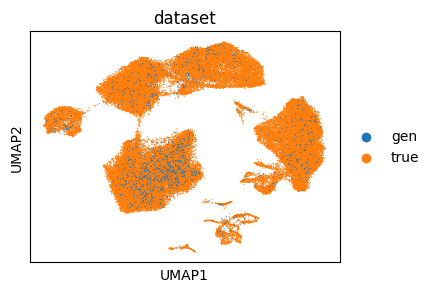

Workig with cluster 11


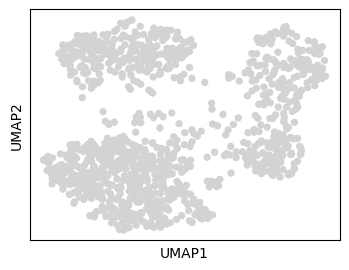

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


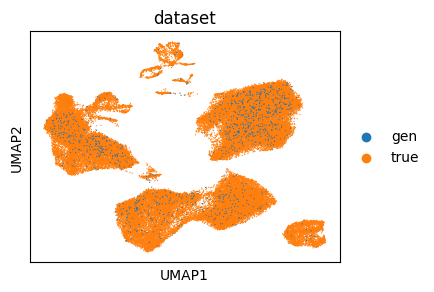

Workig with cluster 12


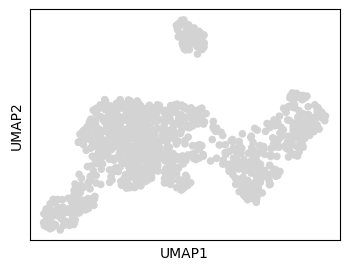

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


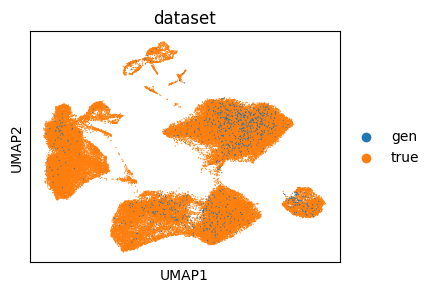

In [130]:
# X_codex = torch.from_numpy(adata_codex.X)

for cl_id in range(13):
    print(f"Workig with cluster {cl_id}")
    X_codex = torch.from_numpy(adata_codex[adata_codex.obs.shared_leiden_cluster_id==str(cl_id)].X)
    hat_adata_rna = model.pushforward(x0=X_codex,
                                    n_timesteps = 100,
                                    solver = "euler")
    hat_adata_rna = hat_adata_rna.detach().cpu().numpy()
    hat_adata_rna_adata = sc.AnnData(X=hat_adata_rna)
    sc.tl.pca(hat_adata_rna_adata)
    sc.pp.neighbors(hat_adata_rna_adata)
    sc.tl.umap(hat_adata_rna_adata)
    sc.pl.umap(hat_adata_rna_adata)
    
    X_tot = np.concatenate([adata_scrnaseq.obsm["HARMONY"], hat_adata_rna], axis=0)
    obs = {"dataset": ["true" for _ in range(adata_scrnaseq.shape[0])] + ["gen" for _ in range(hat_adata_rna.shape[0])]}
    obs = pd.DataFrame(obs)
    adata_joint = sc.AnnData(X=X_tot, obs=obs)
    sc.tl.pca(adata_joint)
    sc.pp.neighbors(adata_joint)
    sc.tl.umap(adata_joint)
    sc.pl.umap(adata_joint, color="dataset", s=3)

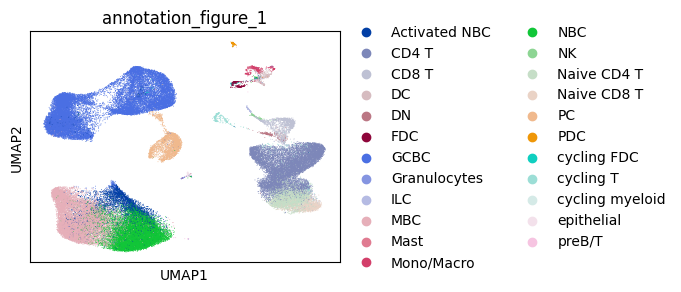

In [138]:
sc.pl.umap(adata_scrnaseq, color='annotation_figure_1')